# Validation Notebook

Set up the parameters in cell below, then run the entire notebook to get a quick summary of the results from the simulation and a framework for further analysis.

## Imports

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import math
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [16]:
RUN_BUNDLE_NAME = "2001-30-CA-M3-100-110"  # REPLACE WITH YOUR DESIRED SIMULATION RUN
PATH_OUTPUT = "output"  # Replace with the path to the output folder
MALE_COLOUR = "#09bfc4"
FEMALE_COLOUR = "#f86d63"
# CSV_INFO key-value pairs follow
# csv_name : {'column_name': `column named in the csv` , 
#             'column_text': `what the graph y axis will display`}
CSV_INFO = {
    'alive': {
        'column_name': 'n_alive',
        'column_text': 'Population size'
    },
    'antibiotic_exposure': {
        'column_name': 'n_antibiotic_exposure',
        'column_text': 'Number of exposures of antibiotics'
    },
    'asthma_incidence_contingency_table': {
        'column_name': 'n_no_asthma',
        'column_text': 'Number of people without asthma (incidence)'
    },
    'asthma_incidence': {
        'column_name': 'n_new_diagnoses',
        'column_text': 'Number of new diagnoses'
    },
    'asthma_prevalence_contingency_table': {
        'column_name': 'n_no_asthma',
        'column_text': 'Number of people without asthma (prevalence)'
    },
    'asthma_prevalence': {
        'column_name': 'n_asthma',
        'column_text': 'Number of people with asthma'
    },
    'asthma_status': {
        'column_name': 'status',
        'column_text': 'Status'
    },
    'control': {
        'column_name': 'prob',
        'column_text': 'Control probability'
    },
    'cost': {
        'column_name': 'cost',
        'column_text': 'Cost (CAD)'
    },
    'death': {
        'column_name': 'n_deaths',
        'column_text': 'Number of deaths'
    },
    'emigration': {
        'column_name': 'n_emigrants',
        'column_text': 'Number of emigrants'
    },
    'exacerbation_by_severity': {
        'column_name': 'p_exacerbations',
        'column_text': 'Exacerbation severity level'
    },
    'exacerbation_hospital': {
        'column_name': 'n_hospitalizations',
        'column_text': 'Number of hospitalizations'
    },
    'exacerbation': {
        'column_name': 'n_exacerbations',
        'column_text': 'Number of exacerbations'
    },
    'family_history': {
        'column_name': 'has_family_history',
        'column_text': 'Number of people with family history'
    },
    'immigration': {
        'column_name': 'n_immigrants',
        'column_text': 'Number of immigrants'
    },
    'utility': {
        'column_name': 'utility',
        'column_text': 'Utility'
    },
}

## Utility Functions

In [17]:
def plot_simulation_csv(
    run_bundle_name: str,
    path_output: str,
    outcome_matrix_csv_name: str,
    num_graphs : int = 6,
    user_linewidth: int = 2
):
    """Plots the simulation results from a CSV file.

    This function reads simulation data from a CSV file and generates a series of plots
    showing the number of alive individuals by age for each year, separated by sex.
    
    Args:
        run_bundle_name: str
            The name of the simulation run bundle, which is used to locate the CSV file.
            
        path_output: str
            The path to the output folder containin the simulation run results.
            
        outcome_matrix_csv_name: str
        - The suffix name of the CSV file containing the simulation data.
            Must be one of the following:
            - 'alive',
            - 'antibiotic_exposure'
            - 'asthma_incidence_contingency_table'
            - 'asthma_incidence'
            - 'asthma_prevalence_contingency_table'
            - 'asthma_prevalence'
            - 'asthma_status'
            - 'control'
            - 'cost'
            - 'death'
            - 'emigration'
            - 'exacerbation_by_severity'
            - 'exacerbation_hospital'
            - 'family_history'
            - 'immigration'
            - 'utility'
    
        num_graphs: int
            The number of plots to display, where each plot corresponds to one year. The number is truncated to be in range [1, years_in_simulation]. (default is 6 or less if under 6 years present in simullation)
    
        user_linewidth: int
            The width of the lines in the plot (default is 2).
        
    Returns:
        This function does not return any value. It displays the plots.
        
    Notes:
        - The CSV file should be located at `output/{run_bundle_name}/{outcome_matrix_csv_name}.csv`.
        - The CSV file should contain columns: "year", "age", and "sex"
        - The function assumes that ``MALE_COLOUR`` and ``FEMALE_COLOUR`` are predefined colors for the plots.
    """
    
    # Read in data from simulation
    csv_file_path = pathlib.Path(path_output, f"{run_bundle_name}/outcome_matrix_{outcome_matrix_csv_name}.csv").resolve()
    df_outcome: pd.DataFrame = pd.read_csv(csv_file_path)

    # Get all unique years in simulation
    years = df_outcome["year"].unique()
    
    # Determine number of graphs to show
    graphs_to_show = min(num_graphs, len(years))
    # Pick graphs_to_show evenly spaced elements from years
    if graphs_to_show > 1:
        indices = np.linspace(0, len(years) - 1, graphs_to_show, dtype=int)
    else:
        indices = [0]
    years_to_show = [years[i] for i in indices]
    
    # Figure parameters
    num_cols = 3
    # Dynamically calculate number of rows based on number of years and number of columns
    num_rows = math.ceil(len(years_to_show) / num_cols)

    # Set up figure and axes
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 3 * num_rows))
    
    # Loop to create plots
    for i, year in enumerate(years_to_show):
        # Index axis to be in 2D grid of size (num_rows x num_cols) using i
        # Determine the current axis
        if num_rows == 1 and num_cols == 1:
            ax: plt.Axes = axs
        elif num_rows == 1 or num_cols == 1:
            ax: plt.Axes= axs[i]
        else:
            ax: plt.Axes = axs[i // num_cols][i % num_cols]

        # Filter simulation data by current year
        df_outcome_modified = df_outcome[df_outcome["year"] == year]

        # Filter by males and females
        df_outcome_M = df_outcome_modified[df_outcome_modified["sex"] == "M"]
        df_outcome_F = df_outcome_modified[df_outcome_modified["sex"] == "F"]
        
        # Get name of column to plot
        column_name = CSV_INFO[outcome_matrix_csv_name]['column_name']
        column_text = CSV_INFO[outcome_matrix_csv_name]['column_text']

        # Plot for males
        ax.plot(df_outcome_M["age"],
                df_outcome_M[column_name],
                color=MALE_COLOUR,
                linewidth=user_linewidth)

        # Plot for females
        ax.plot(df_outcome_F["age"],
                df_outcome_F[column_name],
                color=FEMALE_COLOUR,
                linewidth=user_linewidth)

        # Set axis labels
        ax.set_title(f"{year}", fontsize=12)

    # Get relative path to file to put in title
    title_file = str(csv_file_path.relative_to(pathlib.Path(path_output).resolve()))

    # Additional labels, title, and legend
    fig.supxlabel("Age (year)")
    fig.supylabel(column_text)
    fig.suptitle(f"Summary for <{title_file}>", fontsize=16)
    fig.legend(["male", "female"])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Plot Simulation Results

#### outcome_matrix_alive.csv

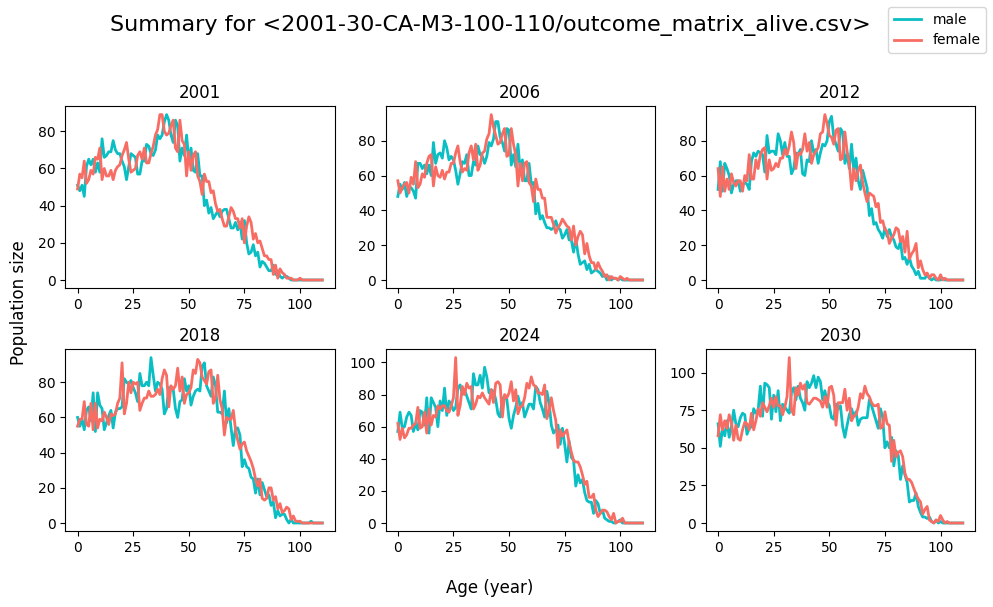

In [21]:
plot_simulation_csv(RUN_BUNDLE_NAME, PATH_OUTPUT, 'alive', num_graphs=6, user_linewidth=2)

#### outcome_matrix_antibiotic_exposure.csv

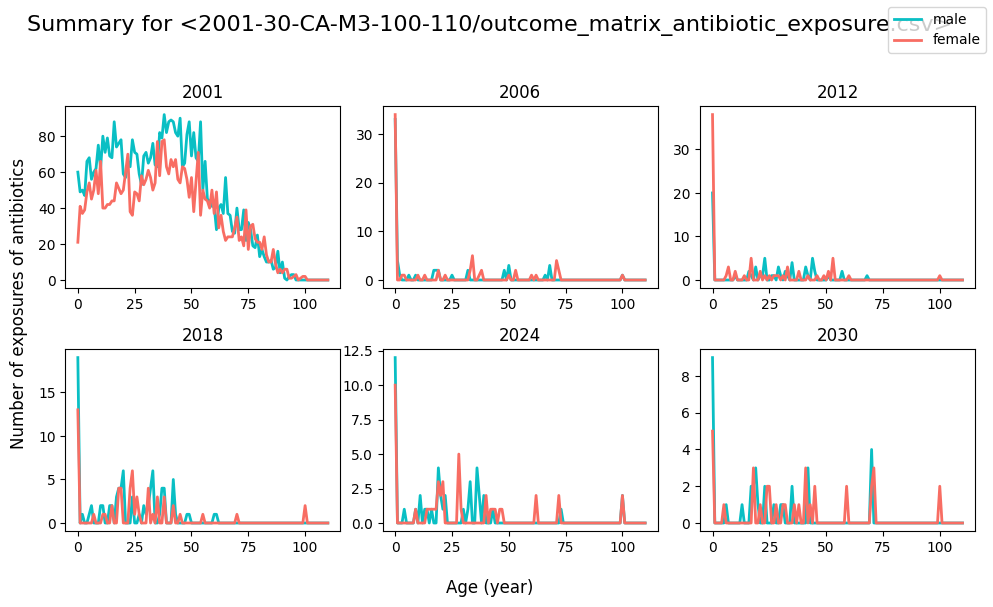

In [22]:
plot_simulation_csv(RUN_BUNDLE_NAME, PATH_OUTPUT, 'antibiotic_exposure', num_graphs=6, user_linewidth=2)

#### outcome_matrix_utility.csv

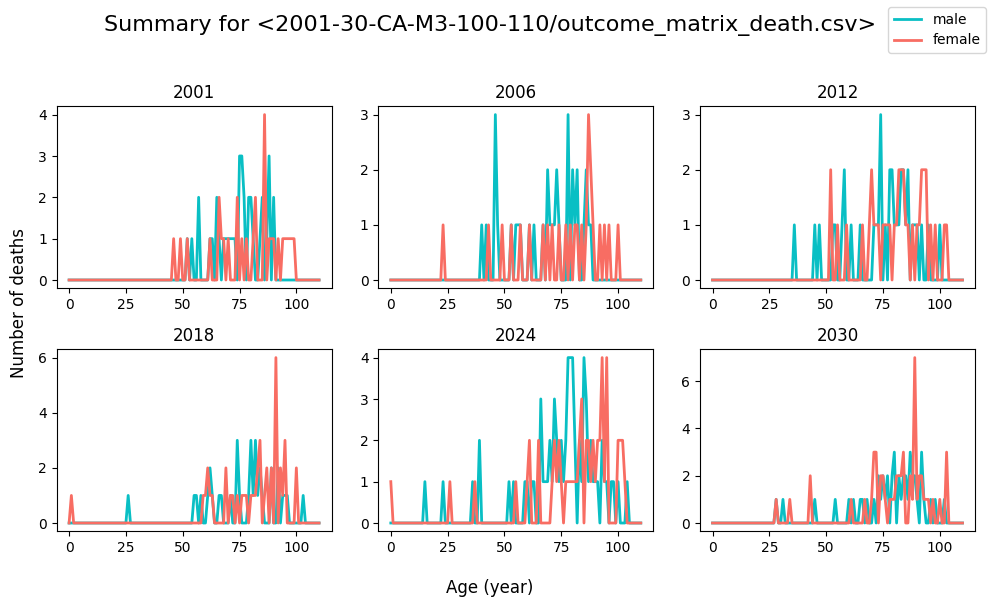

In [23]:
plot_simulation_csv(RUN_BUNDLE_NAME, PATH_OUTPUT, 'death', num_graphs=6, user_linewidth=2)